<a href="https://colab.research.google.com/github/pearlveera/PGAIML---GL/blob/master/Capstone%20GLIM%20NLP%20Ticket%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# libraries

import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## Importing Textblob package
from textblob import TextBlob

# Importing CountVectorizer for sparse matrix/ngrams frequencies
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words("english")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#read the input raw data from excel (Raw transactions of tickets)
df = pd.read_excel('Input Data Synthetic (created but not used in our project).xlsx')

In [0]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [0]:
df.describe(include = np.object).transpose()

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


In [0]:
# Fix the Messy column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,short_description,description,caller,assignment_group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [0]:
df.assignment_group.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_61       1
GRP_35       1
GRP_67       1
GRP_70       1
GRP_73       1
Name: assignment_group, Length: 74, dtype: int64

In [0]:
# find if any null values present
df.isnull().sum()
df1 = df[df.isna().any(axis=1)]
print (df1)


             short_description  ... target
2604                       NaN  ...     28
3383                       NaN  ...      0
3906                       NaN  ...      0
3910                       NaN  ...      0
3915                       NaN  ...      0
3921                       NaN  ...      0
3924                       NaN  ...      0
4341                       NaN  ...      0
4395  i am locked out of skype  ...      0

[9 rows x 5 columns]


In [0]:
# fill the missing value in description with value from short description.
df['description'].fillna(df['short_description'], inplace=True)
 # since short description is having 9 null values, and description has enough data. Dropping short description for now

In [0]:
#Merge Description and Short Description 
df['description'] = df['short_description'] + df['description']

In [0]:
# We dont need the caller and Short description as this data will not help in identifying the group
df.drop('caller', axis=1, inplace=True)
df.drop('short_description', axis=1, inplace=True)
df.head()

,description,assignment_group,target
0,login issue-verified user details.(employee# &...,GRP_0,0
1,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...,GRP_0,0
2,cant log in to vpn\r\n\r\nreceived from: eylqg...,GRP_0,0
3,unable to access hr_tool pageunable to access ...,GRP_0,0
4,skype error skype error,GRP_0,0


In [0]:
df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()

description         0
assignment_group    0
target              0
dtype: int64

In [0]:
#Extract Number of Words from each description
df['num_words'] = df.description.apply(lambda x : len(x.split()))

In [0]:
bins=[0,50,75, np.inf]
df['bins']=pd.cut(df.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
df.head()

,description,assignment_group,target,num_words,bins
0,login issue-verified user details.(employee# &...,GRP_0,0,34,0-100
1,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...,GRP_0,0,26,0-100
2,cant log in to vpn\r\n\r\nreceived from: eylqg...,GRP_0,0,16,0-100
3,unable to access hr_tool pageunable to access ...,GRP_0,0,9,0-100
4,skype error skype error,GRP_0,0,4,0-100


In [0]:
word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [0]:
word_distribution.head()

,bins,counts
0,0-100,8045
1,100-300,404
2,300-500,19
3,500-800,10
4,>800,14


Text(0.5, 1.0, 'Word distribution per bin')

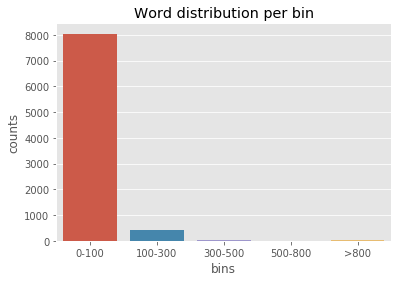

In [0]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [0]:
num_class = len(np.unique(df.assignment_group.values))
y = df['target'].values

In [0]:
# Replace all special characters and numeric with empty
desc = df['description']
# Replace email address with blank
desc = desc.str.replace(r'\S*@\S*\s?', ' ')
# this can also be removed as this is prefix of email address, bigrams without removing stop words confirms the same
desc = desc.str.replace('received from', ' ')
# Replace all special characters and numeric with empty except space as we will need this to identify word count 
# bi and tri grams
desc = desc.str.replace(r'[^a-zA-Z ]', ' ')
# convert everything to lowercase to avoid case sensitive words.
desc = desc.str.lower()

df['description'] = desc
# remove all non english rows from data frame
#df = df[df['Description'].str.isalnum()]
df.rename(columns={'assignment_group':'group'}, inplace=True)

In [0]:
df.head()

,description,group,target,num_words,bins
0,login issue verified user details employee ...,GRP_0,0,34,0-100
1,outlook hello team my meetings s...,GRP_0,0,26,0-100
2,cant log in to vpn hi i cannot lo...,GRP_0,0,16,0-100
3,unable to access hr tool pageunable to access ...,GRP_0,0,9,0-100
4,skype error skype error,GRP_0,0,4,0-100


In [0]:
df['desc_word_count'] = df['description'].apply(lambda x: len(str(x).split()))

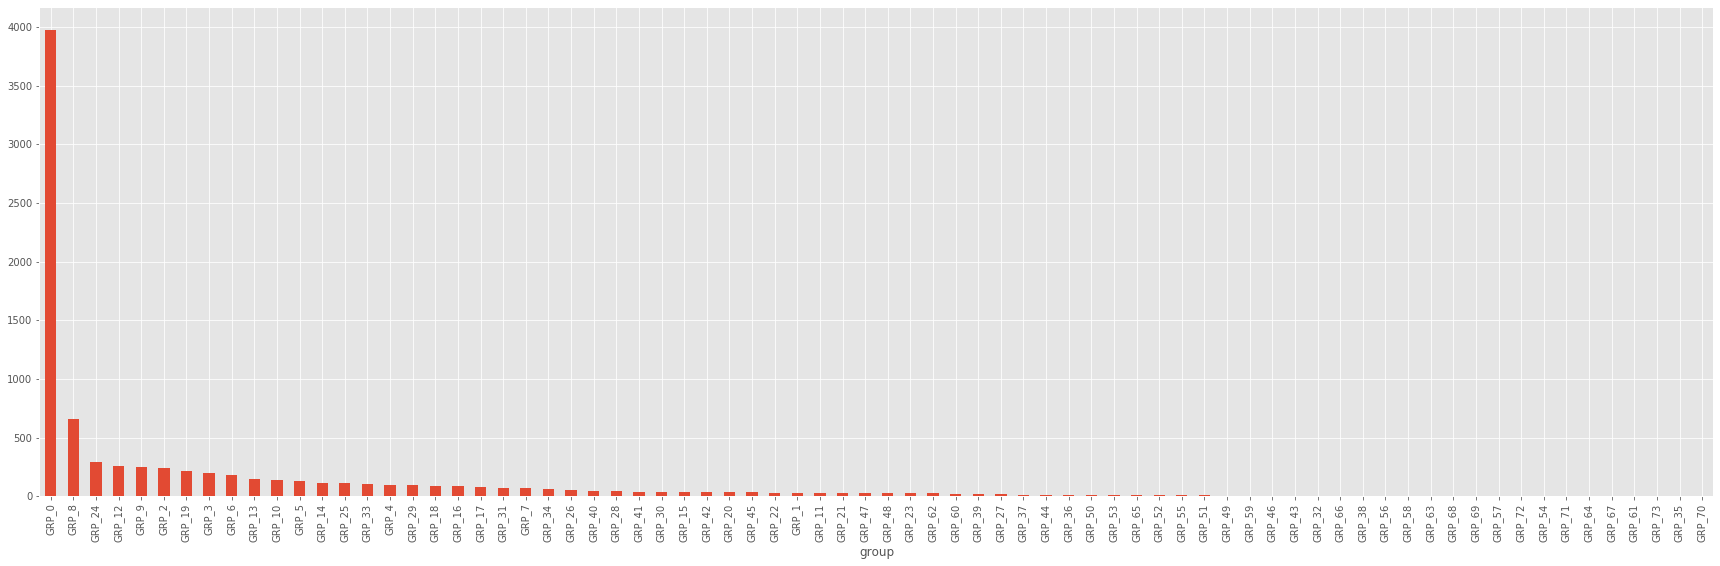

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
df1 = df.groupby('group').description.count()
df1.sort_values(ascending=False).plot.bar(ylim=0,figsize = (30,9))
plt.show()

In [0]:
#Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [0]:
df['description'] =df['description'].astype(str)

In [0]:
type(df['description'])

pandas.core.series.Series

In [0]:
df_description = df.description.values
type(df_description)

numpy.ndarray

In [0]:
# try using TFIDIf
from sklearn.feature_extraction.text import CountVectorizer
# function to find the word count for most occuring words before removing stop words.
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

to 8737
the 6994
in 5233
job 5054
is 3555
no 2968
on 2956
not 2911
and 2767
for 2654
at 2504
password 2265
please 2072
yes 2027
na 2007
scheduler 1928
erp 1905
of 1848
failed 1731
it 1691


In [0]:
# function to find the word count for most occuring words after removing stop words. Corpus is the column and n is 
# number of results you need.
def get_top_n_words_stop(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

job 5054
password 2265
yes 2027
na 2007
scheduler 1928
erp 1905
failed 1731
tool 1684
company 1557
sid 1548
user 1418
access 1399
reset 1359
ticket 1193
issue 1157
unable 1153
account 1105
error 963
hostname 936
outlook 831


In [0]:
# function to find the bigram word count for most occuring words before removing stop words. Corpus is the column and n is 
# number of results you need.
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

job scheduler 1928
in job 1920
yes no 1744
failed in 1615
scheduler at 1613
no na 1570
unable to 1142
job job 964
job failed 947
at job 782
to the 708
is not 659
password reset 559
able to 496
erp sid 494
to login 454
not working 446
backup circuit 437
no yes 427
in the 416


In [0]:
# function to find the bigram word count for most occuring words after removing stop words. Corpus is the column and n is 
# number of results you need.
def get_top_n_bigram_stop(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

job scheduler 1928
failed job 1614
yes na 1570
job job 1266
scheduler job 959
job failed 947
password reset 573
erp sid 502
backup circuit 437
engineering tool 380
telecom vendor 322
collaboration platform 321
password management 307
account locked 306
abended job 300
management tool 295
type outage 286
scheduled maintenance 286
na company 286
na yes 285


In [0]:
# function to find the trigrams word count for most occuring words before removing stop words. Corpus is the column and n is 
# number of results you need.
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

in job scheduler 1920
failed in job 1614
job scheduler at 1613
yes no na 1570
job failed in 946
job job failed 945
scheduler at job 782
at job job 464
no yes no 425
to login to 306
job in job 300
abended job in 298
password management tool 290
type of outage 286
no na company 285
na yes no 285
not able to 263
what type of 258
yes yes no 231
am et on 201


In [0]:
# function to find the trigrams word count for most occuring words after removing stop words. Corpus is the column and n is 
# number of results you need.
def get_top_n_trigram_stop(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

failed job scheduler 1614
job scheduler job 959
job job failed 946
job failed job 946
scheduler job job 465
job job scheduler 300
abended job job 298
password management tool 290
yes na company 285
na yes na 285
backup circuit yes 242
yes yes na 231
management tool password 198
src inside dst 185
access group acl 185
group acl inside 185
ticket update inplant 167
microsoft internet explorer 167
browser microsoft internet 166
language browser microsoft 164


In [0]:
#Declaring a dictionary which keeps the key as group no in the Assignment group column and value as the description column
dict_of_Categorization = {k: v for k, v in df.groupby('group')}
dict_of_Categorization

{'GRP_0':                                             description  ... desc_word_count
 0     login issue verified user details  employee   ...  ...              35
 1     outlook           hello team     my meetings s...  ...              24
 2     cant log in to vpn           hi    i cannot lo...  ...              13
 3     unable to access hr tool pageunable to access ...  ...              11
 4                              skype error skype error   ...               4
 ...                                                 ...  ...             ...
 8488  erp account unlockname mfeyouli ndobtzpw langu...  ...              23
 8489                       account lockedaccount locked  ...               3
 8492  hr tool etime option not visitble hr tool etim...  ...              12
 8496   telephony software issuetelephony software issue  ...               5
 8497  vip   windows password reset for tifpdchb pedx...  ...              13
 
 [3969 rows x 6 columns],
 'GRP_1':                  

In [0]:
# lets recheck the uni, bi and tri after removing stop words
common_words = get_top_n_words_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

job 5054
password 2265
yes 2027
na 2007
scheduler 1928
erp 1905
failed 1731
tool 1684
company 1557
sid 1548
user 1418
access 1399
reset 1359
ticket 1193
issue 1157
unable 1153
account 1105
error 963
hostname 936
outlook 831


In [0]:
common_words = get_top_n_bigram_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

job scheduler 1928
failed job 1614
yes na 1570
job job 1266
scheduler job 959
job failed 947
password reset 573
erp sid 502
backup circuit 437
engineering tool 380
telecom vendor 322
collaboration platform 321
password management 307
account locked 306
abended job 300
management tool 295
type outage 286
scheduled maintenance 286
na company 286
na yes 285


In [0]:
common_words = get_top_n_trigram_stop(df['description'], 20)
for word, freq in common_words:
    print(word, freq)

failed job scheduler 1614
job scheduler job 959
job job failed 946
job failed job 946
scheduler job job 465
job job scheduler 300
abended job job 298
password management tool 290
yes na company 285
na yes na 285
backup circuit yes 242
yes yes na 231
management tool password 198
src inside dst 185
access group acl 185
group acl inside 185
ticket update inplant 167
microsoft internet explorer 167
browser microsoft internet 166
language browser microsoft 164


In [0]:

#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)



tfidf_transformer = TfidfTransformer()


In [0]:
data_description

<8492x9404 sparse matrix of type '<class 'numpy.int64'>'
	with 9404 stored elements in Compressed Sparse Row format>

In [0]:
data_description = df.description.values
type(data_description)

numpy.ndarray

In [0]:
# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)


Streaming output truncated to the last 5000 lines.
lalanne 9.353850393220064
lance 9.353850393220064
lane 9.353850393220064
langer 9.353850393220064
langhdte 9.353850393220064
langmar 9.353850393220064
langmarhello 9.353850393220064
langsadgtym 9.353850393220064
langsamer 9.353850393220064
langsameu 9.353850393220064
langsamtransaktionen 9.353850393220064
languague 9.353850393220064
langytge 9.353850393220064
lanhuage 9.353850393220064
laoding 9.353850393220064
lapels 9.353850393220064
lapping 9.353850393220064
lappingquality 9.353850393220064
laptopfrom 9.353850393220064
laptopname 9.353850393220064
laptopneed 9.353850393220064
laptopneither 9.353850393220064
laptopnot 9.353850393220064
laptopplease 9.353850393220064
laptopsetup 9.353850393220064
laptopsound 9.353850393220064
laptopthomklmas 9.353850393220064
laptoptransfer 9.353850393220064
laqdwvgo 9.353850393220064
lar 9.353850393220064
lara 9.353850393220064
larsffar 9.353850393220064
laserder 9.353850393220064
lat 9.3538503932200

In [0]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [0]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))


Features with lowest idf:
['aacount' 'promoting' 'promotion' 'promptmicrosoft' 'promptsi' 'proms'
 'promtsplease' 'promote' 'proof' 'properlyemail']

Features with highest idf:
['globalmfg' 'glue' 'gm' 'gmail' 'gmkiatjs' 'gmlhrtvp' 'gmnhjfbw'
 'gmrkisxy' 'gleichzeitig' 'zzsdspc']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


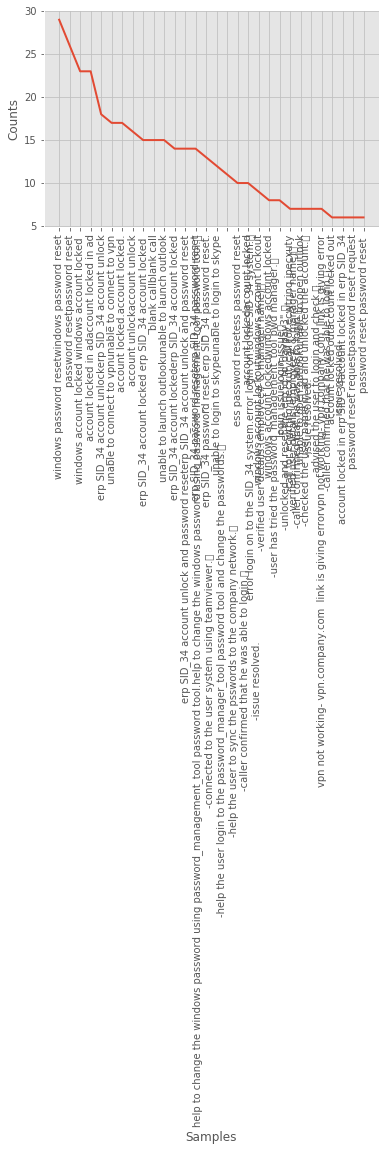

In [0]:
count = nltk.FreqDist(df.description.values)
count.plot(30)

In [0]:
final_doc = df['description']
all_documents = tuple(final_doc)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(8492, 26078)
  (0, 20184)	0.17975172206296453
  (0, 5516)	0.14047213359193692
  (0, 24381)	0.13472491963086916
  (0, 12619)	0.16425883289099344
  (0, 22576)	0.1255507126630977
  (0, 8446)	0.1826237082312799
  (0, 7735)	0.19344305908233533
  (0, 8015)	0.14694634465516576
  (0, 22922)	0.13254231544434347
  (0, 5766)	0.20996141691607922
  (0, 18240)	0.10816214735508387
  (0, 20147)	0.11376601488395209
  (0, 6081)	0.18610942966472724
  (0, 5687)	0.18478681496442145
  (0, 13535)	0.0721750242763535
  (0, 22581)	0.22757398286233613
  (0, 8016)	0.19344305908233533
  (0, 17138)	0.2840064495736138
  (0, 16307)	0.15465886178225344
  (0, 10494)	0.17787493752421998
  (0, 9370)	0.16956838047508857
  (0, 23638)	0.3610913547970641
  (0, 23861)	0.16569420226298917
  (0, 14211)	0.2314552275965927
  (0, 15976)	0.4108734560536621
  :	:
  (8490, 11815)	0.3220643137903659
  (8490, 10857)	0.2743325324001964
  (8490, 17615)	0.27893017877331566
  (8490, 11540)	0.29051532237102246
  (8490, 16203)	0.41716937679

In [0]:
reindexed_data= df["description"]

data_text = df[['description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


8492
                                         description  index
0  login issue-verified user details.(employee# &...      0
1  outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...      1
2  cant log in to vpn\r\n\r\nreceived from: eylqg...      2
3  unable to access hr_tool pageunable to access ...      3
4                           skype error skype error       4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
from wordcloud import WordCloud
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

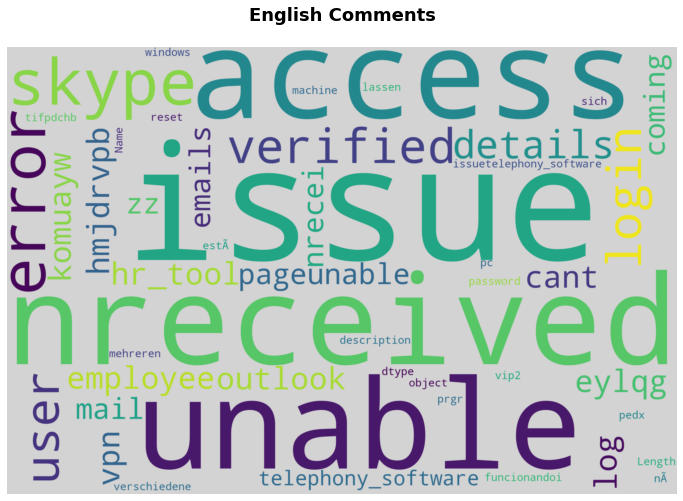

In [0]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df['description']))

plot_wordcloud(wordcloud, 'English')

In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
def remove_stop_words(text):
    return ' '.join([word for word in text.split(' ') if word.lower() not in STOP_WORDS])

In [0]:
df['desc_stopped'] = df['description'].apply(remove_stop_words)

In [0]:
df.head()

,description,group,target,num_words,bins,desc_word_count,desc_stopped
0,login issue verified user details employee ...,GRP_0,0,34,0-100,35,login issue verified user details employee ...
1,outlook hello team my meetings s...,GRP_0,0,26,0-100,24,outlook hello team meetings skyp...
2,cant log in to vpn hi i cannot lo...,GRP_0,0,16,0-100,13,cant log vpn hi log vpn best
3,unable to access hr tool pageunable to access ...,GRP_0,0,9,0-100,11,unable access hr tool pageunable access hr too...
4,skype error skype error,GRP_0,0,4,0-100,4,skype error skype error


In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# implemented lemmatize on the descriotion column.

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,pos='v') for w in w_tokenizer.tokenize(text)]

df['desc_lemmatized'] = df['desc_stopped'].apply(lemmatize_text)

In [0]:
df.head()

,description,group,target,num_words,bins,desc_word_count,desc_stopped,desc_lemmatized
0,login issue verified user details employee ...,GRP_0,0,34,0-100,35,login issue verified user details employee ...,"[login, issue, verify, user, detail, employee,..."
1,outlook hello team my meetings s...,GRP_0,0,26,0-100,24,outlook hello team meetings skyp...,"[outlook, hello, team, meet, skype, meet, etc,..."
2,cant log in to vpn hi i cannot lo...,GRP_0,0,16,0-100,13,cant log vpn hi log vpn best,"[cant, log, vpn, hi, log, vpn, best]"
3,unable to access hr tool pageunable to access ...,GRP_0,0,9,0-100,11,unable access hr tool pageunable access hr too...,"[unable, access, hr, tool, pageunable, access,..."
4,skype error skype error,GRP_0,0,4,0-100,4,skype error skype error,"[skype, error, skype, error]"


In [0]:
unique_words=[]
#unique_words = list(set([word for words in [doc.split(',') for doc in df_subset['desc_lemmatized']]for word in words]))
for doc in df['desc_lemmatized']:
   unique_words=unique_words+doc

In [0]:
print(unique_words)


['login', 'issue', 'verify', 'user', 'detail', 'employee', 'manager', 'check', 'user', 'ad', 'reset', 'password', 'advise', 'user', 'login', 'check', 'caller', 'confirm', 'able', 'login', 'issue', 'resolve', 'outlook', 'hello', 'team', 'meet', 'skype', 'meet', 'etc', 'appear', 'outlook', 'calendar', 'somebody', 'advise', 'correct', 'kind', 'cant', 'log', 'vpn', 'hi', 'log', 'vpn', 'best', 'unable', 'access', 'hr', 'tool', 'pageunable', 'access', 'hr', 'tool', 'page', 'skype', 'error', 'skype', 'error', 'unable', 'log', 'engineer', 'tool', 'skypeunable', 'log', 'engineer', 'tool', 'skype', 'event', 'critical', 'hostname', 'company', 'com', 'value', 'mountpoint', 'threshold', 'oracle', 'sid', 'erpdata', 'event', 'critical', 'hostname', 'company', 'com', 'value', 'mountpoint', 'threshold', 'oracle', 'sid', 'erpdata', 'sr', 'psa', 'd', 'sr', 'psa', 'd', 'data', 'perpsr', 'psa', 'd', 'ticket', 'employment', 'status', 'new', 'non', 'employee', 'enter', 'user', 's', 'ticket', 'employment', 's

In [0]:
!python -m spacy download en_core_web_lg

# Need to REviese and Check the code boase

     |████████████████████████████████| 826.9MB 70.0MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255078 sha256=13c33688c0179ff9b9e655dfea2bd8db575f06b215234df5bb0d6cbfba176e65
  Stored in directory: /tmp/pip-ephem-wheel-cache-yupnwivf/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 5].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['description'].map(preprocess)
processed_docs[:5]

original document: 
['unable', 'to', 'log', 'in', 'to', 'engineering', 'tool', 'and', 'skypeunable', 'to', 'log', 'in', 'to', 'engineering', 'tool', 'and', 'skype']


 tokenized and lemmatized document: 
['unabl', 'engin', 'tool', 'skypeun', 'engin', 'tool', 'skype']


0    [login, issu, verifi, user, detail, employe, m...
1    [outlook, receiv, hmjdrvpb, komuaywn, gmail, h...
2            [receiv, eylqgodm, ybqkwiam, gmail, best]
3    [unabl, access, hr_tool, pageun, access, hr_to...
4                         [skype, error, skype, error]
Name: description, dtype: object

In [0]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 advis
2 caller
3 check
4 confirm
5 detail
6 employe
7 issu
8 login
9 manag
10 password


In [0]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(30, 1), (52, 1), (104, 2), (262, 2)]

In [0]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 30 ("unabl") appears 1 time.
Word 52 ("report") appears 1 time.
Word 104 ("display") appears 2 time.
Word 262 ("expens") appears 2 time.


In [0]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.17021701822886212),
 (1, 0.2248841787780159),
 (2, 0.25570895433825747),
 (3, 0.3415732654110117),
 (4, 0.21577145774462436),
 (5, 0.21024163499570123),
 (6, 0.2184187719774111),
 (7, 0.244045787008212),
 (8, 0.49216996746525726),
 (9, 0.1845293312669169),
 (10, 0.11693475027450159),
 (11, 0.12658872267639917),
 (12, 0.19750471532949157),
 (13, 0.3913538584106498),
 (14, 0.20548281710003322)]


In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [0]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.056*"job_schedul" + 0.049*"fail" + 0.041*"account" + 0.037*"compani" + 0.035*"receiv" + 0.031*"job_" + 0.030*"sid_" + 0.028*"monitoring_tool" + 0.022*"user" + 0.020*"issu" + 0.015*"lock" + 0.014*"access" + 0.013*"unlock" + 0.011*"need" + 0.010*"gmail" + 0.009*"printer" + 0.007*"outlook" + 0.007*"error" + 0.006*"help" + 0.006*"work" + 0.005*"print" + 0.005*"attach" + 0.005*"get" + 0.005*"email" + 0.005*"check"'), (1, '0.035*"fail" + 0.031*"job_schedul" + 0.029*"compani" + 0.026*"hostname_" + 0.023*"receiv" + 0.023*"event" + 0.019*"job_" + 0.016*"monitoring_tool" + 0.013*"devic" + 0.013*"server" + 0.013*"connect" + 0.012*"sid_" + 0.011*"access" + 0.010*"space" + 0.010*"deni" + 0.009*"insid" + 0.009*"time" + 0.009*"sourc" + 0.009*"account" + 0.008*"group" + 0.008*"gmail" + 0.008*"issu" + 0.008*"lock" + 0.007*"nicht" + 0.007*"port"'), (2, '0.051*"password" + 0.035*"reset" + 0.028*"gmail" + 0.021*"sid_" + 0.018*"site" + 0.017*"work" + 0.016*"compani" + 0.016*"receiv" + 0.015*"user" 

In [0]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

In [0]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 21.1MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=1806cf5f400d40aee911824202cf9b43bef3430bf1f2ee399e6ed7992515ad06
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3750558ac7c0a068bb6792fb99b384055dbef4462b9e7bd215c12c99d8c1f177
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [0]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [0]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.056*"job_schedul" + 0.049*"fail" + 0.041*"account" + 0.037*"compani" + 0.035*"receiv" + 0.031*"job_" + 0.030*"sid_" + 0.028*"monitoring_tool" + 0.022*"user" + 0.020*"issu"
Topic: 1 
Words: 0.035*"fail" + 0.031*"job_schedul" + 0.029*"compani" + 0.026*"hostname_" + 0.023*"receiv" + 0.023*"event" + 0.019*"job_" + 0.016*"monitoring_tool" + 0.013*"devic" + 0.013*"server"
Topic: 2 
Words: 0.051*"password" + 0.035*"reset" + 0.028*"gmail" + 0.021*"sid_" + 0.018*"site" + 0.017*"work" + 0.016*"compani" + 0.016*"receiv" + 0.015*"user" + 0.014*"email"
Topic: 3 
Words: 0.039*"ticket" + 0.034*"updat" + 0.025*"compani" + 0.020*"abend" + 0.014*"access" + 0.013*"inplant_" + 0.011*"job_schedul" + 0.010*"server" + 0.010*"error" + 0.010*"receiv"
Topic: 4 
Words: 0.029*"gmail" + 0.023*"unabl" + 0.022*"receiv" + 0.020*"connect" + 0.020*"compani" + 0.017*"user" + 0.016*"error" + 0.016*"issu" + 0.015*"open" + 0.013*"need"


In [0]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [0]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(70, 5)
(5, 70)


In [0]:
df_lda

,job_schedul,fail,account,compani,receiv,job_,sid_,monitoring_tool,user,issu,lock,access,unlock,need,gmail,printer,outlook,error,help,work,print,attach,get,email,check,hostname_,event,devic,server,connect,space,deni,insid,time,sourc,group,nicht,port,password,reset,site,circuit,power,outag,backup,unabl,login,chang,start,ticket,provid,request,updat,abend,inplant_,ticket_no,agent,network,problem,abl,portal,manag,open,skype,messag,imag,hello,team,engin,tool
0,0.055709,0.049163,0.040629,0.037095,0.034619,0.031161,0.029979,0.027961,0.022354,0.020123,0.014698,0.014448,0.012631,0.011182,0.009782,0.00923,0.006802,0.006631,0.005613,0.005508,0.005465,0.00526,0.005195,0.004811,0.004587,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.031446,0.034810,0.008851,0.028784,0.023158,0.019028,0.012025,0.016426,0.000000,0.007617,0.007559,0.011124,0.000000,0.000000,0.007996,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.025582,0.023114,0.01333,0.013138,0.012508,0.009984,0.009873,0.009245,0.00914,0.008946,0.008135,0.007254,0.007213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.016309,0.016281,0.000000,0.020674,0.000000,0.015463,0.008465,0.000000,0.011118,0.000000,0.000000,0.028190,0.00000,0.010402,0.000000,0.012337,0.016834,0.000000,0.00000,0.000000,0.014280,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.050915,0.035019,0.017676,0.012855,0.010893,0.010813,0.010658,0.009926,0.009609,0.009324,0.009087,0.009067,0.008123,0.008081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.011092,0.000000,0.000000,0.025457,0.009729,0.008698,0.000000,0.005680,0.000000,0.000000,0.000000,0.014186,0.000000,0.008831,0.000000,0.00000,0.000000,0.009755,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.010108,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.009437,0.000000,0.006432,0.000000,0.006631,0.000000,0.005319,0.000000,0.000000,0.009469,0.000000,0.038708,0.000000,0.000000,0.034063,0.019756,0.012812,0.009464,0.008042,0.007311,0.007227,0.007179,0.00572,0.005306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.019636,0.022167,0.000000,0.000000,0.000000,0.016774,0.015596,0.000000,0.012363,0.000000,0.013149,0.028983,0.00000,0.007679,0.015924,0.007174,0.011351,0.000000,0.00000,0.000000,0.010963,0.000000,0.007278,0.000000,0.00000,0.000000,0.020311,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.007067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023170,0.011425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.015202,0.011998,0.009753,0.009231,0.008282,0.007793,0.007559,0.006677


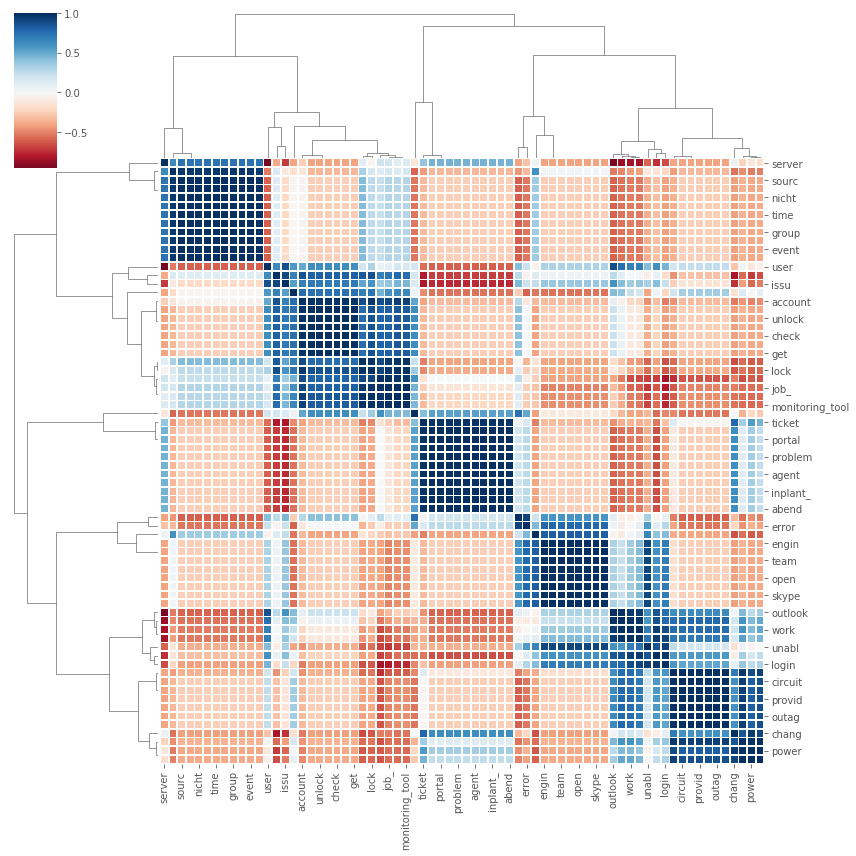

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [0]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.description.values)
post_seq = tokenizer.texts_to_sequences(df.description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

In [0]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)

In [0]:
#Deep Learning

inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          3408640   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 74)                2442      
Total params: 5,459,114
Trainable params: 5,459,114
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6050

In [0]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.5741176470588235

In [0]:
#RNN
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model_lstm = Model(inputs=[inputs], outputs=predictions)
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model_lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          3408640   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 74)                2442      
Total params: 3,462,570
Trainable params: 3,462,570
Non-trainable params: 0
_________________________________________________________________


In [0]:
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20, callbacks=[checkpointer])

Train on 6050 samples, validate on 2017 samples
Epoch 1/20
6050/6050 [==============================] - 70s 12ms/step - loss: 2.9596 - acc: 0.4646 - val_loss: 2.3417 - val_acc: 0.5320

Epoch 00001: val_acc improved from -inf to 0.53198, saving model to weights.hdf5
Epoch 2/20
6050/6050 [==============================] - 69s 11ms/step - loss: 2.0632 - acc: 0.5456 - val_loss: 2.0709 - val_acc: 0.5449

Epoch 00002: val_acc improved from 0.53198 to 0.54487, saving model to weights.hdf5
Epoch 3/20
6050/6050 [==============================] - 69s 11ms/step - loss: 1.7944 - acc: 0.5848 - val_loss: 1.9809 - val_acc: 0.5662

Epoch 00003: val_acc improved from 0.54487 to 0.56619, saving model to weights.hdf5
Epoch 4/20
6050/6050 [==============================] - 69s 11ms/step - loss: 1.5768 - acc: 0.6050 - val_loss: 1.9212 - val_acc: 0.5642

Epoch 00004: val_acc did not improve from 0.56619
Epoch 5/20
6050/6050 [==============================] - 69s 11ms/step - loss: 1.3901 - acc: 0.6362 - val_

In [0]:
model_lstm.load_weights('weights.hdf5')
predicted = model_lstm.predict(X_test)

In [0]:
predicted

array([[1.31907508e-01, 2.23018069e-05, 1.17062256e-04, ...,
        3.45198168e-05, 5.80103142e-06, 1.44052552e-03],
       [1.80798036e-03, 4.10860963e-03, 1.19014857e-02, ...,
        6.66048095e-07, 8.63562600e-05, 5.91600510e-05],
       [9.80969667e-01, 4.53584192e-09, 7.42674786e-07, ...,
        3.26688232e-09, 3.21145905e-07, 3.21309187e-07],
       ...,
       [9.96100187e-01, 4.40482179e-10, 6.59085497e-09, ...,
        5.45450396e-09, 2.48661305e-08, 5.13740474e-07],
       [1.88595513e-05, 5.34059771e-04, 1.59256086e-01, ...,
        9.31950694e-07, 3.30525311e-03, 5.79872370e-01],
       [9.43733990e-01, 2.09436006e-08, 4.23086306e-07, ...,
        7.81191787e-08, 2.34395520e-06, 2.09153677e-05]], dtype=float32)

In [0]:
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)